# ACCURACY OF LINEAR MODELS

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Antimony Models

### Linear Model

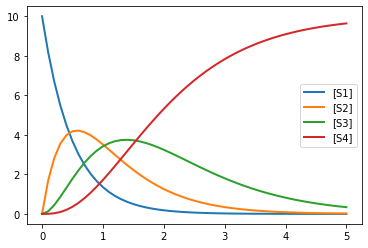

In [2]:
LINEAR_MDL = """
JL1: S1 -> S2; k1*S1
JL2: S2 -> S3; k2*S2
JL3: S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)

### Nonlinear Model

This is a non-linear model because of the presence of a reaction with two reactions, ``JN2``,
with mass action kinetics.

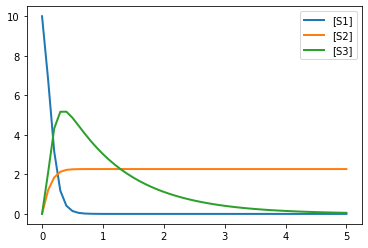

In [3]:
NONLINEAR_MDL = """
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

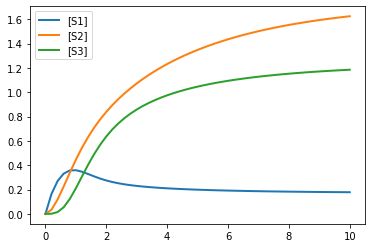

In [4]:
NONLINEAR_STEP_MDL = """
JN0: -> S1; 1
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 0
S2 = 0
S3 = 0
"""
rr = te.loada(NONLINEAR_STEP_MDL)
rr.simulate(0, 10)
rr.plot()

In [5]:
NONLINEAR_RR.model.getFloatingSpeciesIds()

['S1', 'S2', 'S3']

## Constants

In [6]:
# Find the values of the species at time 0.3
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0, 0.3)
for species in ["S1", "S2", "S3"]:
    print("%s: %2.2f" % (species, NONLINEAR_RR[species]))

S1: 1.18
S2: 2.13
S3: 5.17


# Helpers

In [7]:
def getStateDct(time, roadrunner=NONLINEAR_RR):
    """
    Retrieves the value of state at the specified time.
    Changes the time of the roadrunner.
    
    Parameters
    ----------
    time: float
    roadrunner: ExtendedRoadrunner
    
    Returns
    -------
    dict
        key: species name
        value: species value
    """
    roadrunner.reset()
    if time > 0:
        roadrunner.simulate(0, time)
    species_lst = roadrunner.getFloatingSpeciesIds()
    dct = {s: roadrunner[s] for s in species_lst}
    return dct
        
# Tests
dct = getStateDct(0)
assert(len(dct) == 3)
dct1 = getStateDct(1)  # Get different values at a different time
assert(all([dct[s] != dct1[s] for s in dct.keys()]))
print("OK!")

OK!


In [8]:
def getStateValues(time, **kwargs):
    """
    Gets the values of state at the specified time.
    
    Parameters
    ----------
    time: float
    kwargs: dict
        keyword arguments for getStateDct
        
    Returns
    -------
    np.array
    """
    return np.array(list(getStateDct(time, **kwargs).values()))
        
# Tests
arr = getStateValues(0)
assert(isinstance(arr, np.ndarray))
assert(len(arr) == 3)
print("OK!")

OK!


In [9]:
def plotRR(roadrunner=NONLINEAR_RR, is_plot=True):
    """
    Plots species from running a simulation.
    """
    roadrunner.reset()
    roadrunner.simulate(0, 5, 100)
    if is_plot:
        roadrunner.plot()

# Tests
plotRR(is_plot=False)
print("OK!")

OK!


# Constructing a Linear Approximation

Here, we show how to construct a linear approximation for a nonlinear reaction network.
The running example is ``NONLINEAR_MDL``.

The state vector is ${\bf x} = [S_1, S_2, S_3]^T$.

1. Choose an operating point, $\bar{\bf x}$.
1. Calculate the Jacobian, ${\bf A}$, of the system equations at the operating point.
1. Solve the linear system $\dot{\tilde {\bf x}}  = {\bf A} {\tilde {\bf x}}$ to obtain $\tilde {\bf x} (t)$.
1. Calculate the approximation for ${\bf x}(t) \approx \bar{\bf x} + \tilde{\bf x}(t)$.

## 1: Choose an operating point

In the sequel, we'll use $\bar{x} = [ \bar{S}_1, \bar{S}_2, \bar{S}_3 ]^T = [1.18,~ 2.13,~ 5.17]^T$.
We use $N$ to denote the number of states.

$\tilde {\bf x} = {\bf x} - \bar{ \bf x}$

In [10]:
OP_VEC = np.array([1.18, 2.13, 5.17])
OP_TIME = 0.3
NUM_STATE = len(OP_VEC)
X0 = getStateValues(0)
X0

array([10.,  0.,  0.])

## 2: Calculate the Jacobian at the operating point

## 3: Solve the linear system for $\tilde{x}$

We'll use the ``control`` package to construct a transfer function.
This means that we need to specify the input and output.
For this example, the input is $S_1$ and the output is $S_3$.
So, $G(s) = \frac{S_3(s)}{S_1(s)}$.

The first substep is to create a ``StateSpace`` object
that has $S_1$ as its input and $S_3$ as its output.

\begin{eqnarray}
\dot {\tilde {\bf x}} &=& A \tilde{ {\bf x}} + {\bf B} u \\
y & = & {\bf C} \tilde{ {\bf x}} + {\bf D}  u \\
\end{eqnarray}

Note that $y$, ${\bf x}$, and $u$ are a function of time.
Beause this is a Single Input Single Output (SISO) system, the input $u$ and the output $y$ are scalars for any time $t$.

In [11]:
# Obtain the Jacobian at the operating point
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0, OP_TIME)
A = NONLINEAR_RR.getFullJacobian()
A

           S1,       S2,       S3
S1 [[ -10.362, -1.76577, -1.17718],
S2  [ 1.38808, -1.76577, 0.588591],
S3  [ 7.00246,  5.29732, -1.58859]]

### Construct the state space matrices

Now, we have to construct ${\bf B}, ${\bf C}$, ${\bf D}$.

${\bf B}$ has dimension $N \times 1$ since there is one input.
This input is $S_1$.
So, $u$ should only affect $S_1$.
That is,
${\bf B} =
\begin{bmatrix}
1 \\
0 \\
0\\
\end{bmatrix}.
$

In [12]:
B = np.array([1, 0, 0])
B = np.reshape(B, (NUM_STATE, 1))
np.shape(B)

(3, 1)

${\bf C}$ has dimension $1 \times N$ since there is only one output.
This output is $S_1$.
So, we want to select only $S_3$ output of the state vector.
That is,
${\bf C} =
\begin{bmatrix}
0 \\
0 \\
1\\
\end{bmatrix}.
$

In [13]:
C = np.array([0, 0, 1])
C = np.reshape(C, (1, NUM_STATE))
np.shape(C)

(1, 3)

${\bf D}$ is not used in this model, and so it should be all zeroes.
It must have the same number of rows as there are outputs, and the same number of columns as there are inputs.
So, ${\bf D} = 0$.

In [14]:
D = 0

### Construct the ``control`` objects

In [15]:
NONLINEAR_SS_1_3 = control.StateSpace(A, B, C, D)
NONLINEAR_SS_1_3

StateSpace(array([[-10.36196935,  -1.76577345,  -1.1771823 ],
       [  1.38807859,  -1.76577345,   0.58859115],
       [  7.00246286,   5.29732035,  -1.58859115]]), array([[1.],
       [0.],
       [0.]]), array([[0., 0., 1.]]), array([[0.]]))

In [16]:
# Make a transfer function from the state space object
NONLINEAR_TF_1_3 = control.ss2tf(NONLINEAR_SS_1_3)
NONLINEAR_TF_1_3

TransferFunction(array([ 7.00246286, 19.71785996]), array([ 1.        , 13.71633395, 45.13916703, 31.14110895]))

In [17]:
NONLINEAR_TF_1_3.dcgain()

0.6331778354531605

### Run a simulation With the Transfer Function Object

We will do the simulation using ``control.

In [18]:
times = [0.1*v for v in range(51)]
result = control.forced_response(NONLINEAR_SS_1_3, times, X0=getStateValues(0))

Note that we did not adjust for $\tilde{\bf x}$.
The ``control`` package somehow incorporates this adjustment.

(0.0, 10.0)

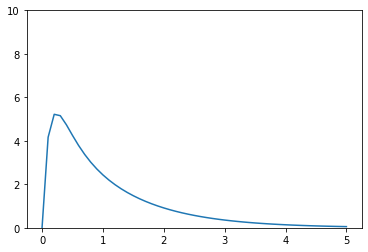

In [19]:
plt.plot(result.t.flatten(), result.y.flatten())
plt.ylim([0, 10])

In [20]:
result.outputs

array([0.        , 4.16599691, 5.21966592, 5.15569491, 4.73871652,
       4.25087065, 3.78803322, 3.37632413, 3.01731249, 2.70511673,
       2.43255575, 2.19312624, 1.98145429, 1.79323748, 1.62505361,
       1.47416513, 1.33835658, 1.21580912, 1.10500712, 1.00466922,
       0.91369792, 0.83114222, 0.75617003, 0.68804727, 0.62612202,
       0.56981221, 0.5185959 , 0.47200348, 0.4296113 , 0.39103642,
       0.35593209, 0.32398397, 0.29490683, 0.26844166, 0.24435312,
       0.22242729, 0.20246966, 0.1843033 , 0.16776729, 0.15271518,
       0.13901373, 0.12654169, 0.11518871, 0.10485435, 0.0954472 ,
       0.08688405, 0.07908918, 0.07199365, 0.0655347 , 0.05965523,
       0.05430325])

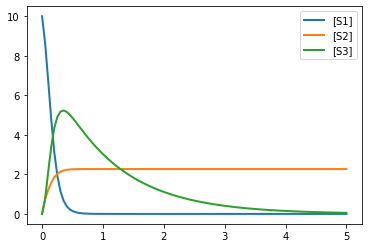

In [21]:
plotRR()

For example, when $t=0$, $S_1 = 10$, $S_2 = 0$, $S_3 = 0$.
So

$\frac{\partial k_2 S_1 S_2}{\partial S_1} |_{\bar{S}_1, \bar{S}_2} = (1.5)(10) = 15$

$\frac{\partial k_2 S_1 S_2}{\partial S_2} |_{\bar{S}_1, \bar{S}_2} = (1.5)(0) = 0$.

Rather than linearizing each kinetics expression separately, we linearize all of them at once.
To see this, we need a vector expression of the kinetics.
Let ${\bf x}$ be the vector representation of the state values.
In ``NONLINEAR_MDL``, ${\bf x} = [S_1, S_2, S_3]^T$.
The time derivative of the state vector is
$\dot{ {\bf x}}$.

The linearization relies on the **stoichiometry matrix**, denoted by
${\bf N}$.
${\bf N}$ describes the mass transformations
of each reaction.
Its rows are species, and its columns are reactions.
Cell $i,j$ indicates the net product of species $i$ in reaction $j$.


$
{\bf N} = 
\begin{bmatrix}
-1 & -1 & 0 & -1\\
1 & -1 & 0 & 1\\
0 & 1 & -1 & -1\\
\end{bmatrix}
$

To illustrate, the stoichiometry matrix for ``NONLINEAR_MDL``: 
$
{\bf v} = 
\begin{bmatrix}
k_1 S_1 \\
k_2 S_1 S_2 \\
k_3 S_3 \\
k_4 S_1 S_3\\
\end{bmatrix}.
$

And so
$\dot{{\bf x}} = 
\begin{bmatrix}
\dot{S}_1 \\
\dot{S}_2 \\
\dot{S}_3 \\
\end{bmatrix}
=
{\bf N} {\bf v} = 
\begin{bmatrix}
-k_1 S_1 -k_2 S_1 S_2 - k_4 S_1 S_3 \\
k_1 S_1 - k_2 S_1 S_2 + k_4 S_1 S_3 \\
k_2 S_1 S_2 -k_3 S_3 -k_4 S_1 S_3
\end{bmatrix}.
$

An operating point is values assigned to the state vector ${\bf x}$.
That is, we use the values of the state variables at some time $t$ in the simulation,
${\bf x}(t)$.
For example, in ``NONLINEAR_MDL``, ${\bf x}(0) = [10, 0]$.

Linearizing the state vector means approximating it at an operating point.
We denote the operating point by ${\bf x}_O$.

$\dot{\bf{x}} \approx {\bf N} \frac{\partial v}{\partial {\bf x}} |_{{\bf x}_O} ({\bf x} - {\bf x}_)$

Clearly, $\dot{ {\bf x}}$ is a nonlinear function of ${\bf x}$.
We can linearlize $\dot{ {\bf x}}$ using a Taylor Series
by taking partial derivatives with respect to ${\bf x}$.
We choose a time $t_0$ and then calculate
$\dot{ {\bf x}} \approx \dot{ {\bf x}} (t_0) + \frac{\partial \dot{ {\bf x}} } {\partial {\bf x}} |_{ {\bf x}(t_0)} \delta {\bf x}$.